In [212]:
import os
import torch
import csv
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

#constant declaration
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
BATCH_SIZE = 32

In [466]:
%store -r benign_flows  
%store -r mixed_flows
%store -r features

mixed_flows

,Unnamed: 0.1,Unnamed: 0.1.1,start,end,count,avergae_packet_size,syn_packets,synack_packets,ack_packets,data_packets,total_bytes,flow_count,is_attack
0,0,75114,1.540463e+09,1.540463e+09,633,58.0,197.0,196.0,22.0,21.0,36964.0,19.0,True
1,1,132179,1.527920e+09,1.527920e+09,825,573.0,80.0,80.0,480.0,229.0,472949.0,38.0,True
2,2,129004,1.540275e+09,1.540275e+09,81,83.0,11.0,11.0,25.0,21.0,6792.0,20.0,True
3,3,80833,1.528268e+09,1.528268e+09,1011,313.0,202.0,203.0,296.0,193.0,316753.0,30.0,True
4,4,130374,1.527903e+09,1.527903e+09,1059,424.0,173.0,173.0,435.0,223.0,449397.0,26.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27723,29639,129537,1.540280e+09,1.540280e+09,117,176.0,3.0,3.0,58.0,48.0,20708.0,28.0,False
27724,29640,193933,1.540176e+09,1.540176e+09,92,164.0,3.0,3.0,43.0,38.0,15147.0,21.0,False
27725,29642,10828,1.528180e+09,1.528180e+09,432,708.0,4.0,4.0,317.0,198.0,306284.0,26.0,False
27726,29643,181224,1.529504e+09,1.529504e+09,105,242.0,3.0,3.0,50.0,50.0,25432.0,20.0,False


In [467]:
# For full dataset, run tran_feature_selection notebook before this one
# For small subset of data, run tran_sample_preprocessing notebook beofore this one (ideal for testing model on CPU)


dim = len(features)

hyperparam_description = f'LR={LEARNING_RATE}, BatchSize={BATCH_SIZE}, #Features={len(features)}'
print(hyperparam_description)

#TODO look into scalars vs normalizers --> https://datascience.stackexchange.com/questions/45900/when-to-use-standard-scaler-and-when-normalizer

normalizer = preprocessing.Normalizer(norm="l2")
normalized_train = normalizer.fit_transform(benign_flows[features]) #axis?
train_X = pd.DataFrame(normalized_train, columns = features)

mixed_flows = mixed_flows.fillna(method='ffill')

normalized_test = normalizer.transform(mixed_flows[features])
test_X = pd.DataFrame(normalized_test, columns = features)
test_y = mixed_flows.is_attack
train_X

LR=0.0001, BatchSize=32, #Features=7


,avergae_packet_size,syn_packets,synack_packets,ack_packets,data_packets,total_bytes,flow_count
0,0.001311,0.000009,0.000009,0.000987,0.000422,0.999999,0.000038
1,0.003565,0.000057,0.000057,0.001966,0.001952,0.999990,0.000424
2,0.003372,0.000294,0.000294,0.002029,0.000826,0.999992,0.000714
3,0.001715,0.000009,0.000009,0.001027,0.000565,0.999998,0.000048
4,0.005847,0.000121,0.000121,0.002515,0.002484,0.999976,0.000667
...,...,...,...,...,...,...,...
49995,0.002583,0.000011,0.000011,0.000995,0.000676,0.999996,0.000075
49996,0.005622,0.000117,0.000117,0.002447,0.002447,0.999978,0.000816
49997,0.004495,0.000111,0.000111,0.001998,0.001868,0.999986,0.000444
49998,0.016537,0.000149,0.000149,0.003576,0.003874,0.999843,0.003427


In [215]:
#dataset loading
train_tensor = torch.tensor(train_X.values.astype(np.float32))
train_loader = torch.utils.data.DataLoader(train_tensor, batch_size = BATCH_SIZE, shuffle = True)
train_tensor

tensor([[1.4240e-03, 5.3001e-06, 5.3001e-06,  ..., 5.0528e-04, 1.0000e+00,
         4.4168e-05],
        [1.9872e-03, 0.0000e+00, 0.0000e+00,  ..., 4.5986e-04, 1.0000e+00,
         4.4578e-05],
        [1.9585e-03, 7.6207e-06, 7.6207e-06,  ..., 5.5631e-04, 1.0000e+00,
         5.5885e-05],
        ...,
        [1.2246e-02, 3.3705e-04, 3.3705e-04,  ..., 3.4828e-03, 9.9991e-01,
         2.8087e-03],
        [1.3696e-02, 1.2229e-04, 1.2229e-04,  ..., 1.8955e-03, 9.9990e-01,
         1.1618e-03],
        [7.9969e-03, 1.3788e-04, 1.3788e-04,  ..., 3.5848e-03, 9.9995e-01,
         1.7924e-03]])

In [216]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.enc1 = nn.Linear(in_features=dim, out_features=5)
        self.enc2 = nn.Linear(in_features=5, out_features=4)
        
        # decoder 
        self.dec1 = nn.Linear(in_features=4, out_features=5)
        self.dec2 = nn.Linear(in_features=5, out_features=dim)
        
    def forward(self, x):
        # relu alternative: torch.sigmoid
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))

        x = F.relu(self.dec1(x))
        x = F.sigmoid(self.dec2(x))
        return x

In [217]:
import pickle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Autoencoder()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
#Training model

# Alternative loss functions - BCEWithLogitsLoss(), BCELoss()
loss_function = nn.MSELoss() # Switching from BCELoss 

train_loss = []
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for data in train_loader:
        input_data = data.to(device=device)
        optimizer.zero_grad()
        output = net(input_data).to(device=device)                  # output is the reconstruced x 
        loss = loss_function(output, input_data).to(device=device)  # input_data should be the target variable
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    loss = running_loss / len(train_loader)
    train_loss.append(loss)
    pickle.dump(net, open("model", 'wb'))
    
    if epoch % 5 == 0:
        print('Epoch {} of {}, Train Loss: {:.5f}'.format(
          epoch+1, NUM_EPOCHS, loss))
print("Completed training with final loss {:.5f}".format(train_loss[-1]))

/users/grad/fali/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1 of 50, Train Loss: 0.14997
Epoch 6 of 50, Train Loss: 0.00012
Epoch 11 of 50, Train Loss: 0.00012
Epoch 16 of 50, Train Loss: 0.00011
Epoch 21 of 50, Train Loss: 0.00010
Epoch 26 of 50, Train Loss: 0.00005
Epoch 31 of 50, Train Loss: 0.00002
Epoch 36 of 50, Train Loss: 0.00001
Epoch 41 of 50, Train Loss: 0.00001
Epoch 46 of 50, Train Loss: 0.00001
Completed training with final loss 0.00001


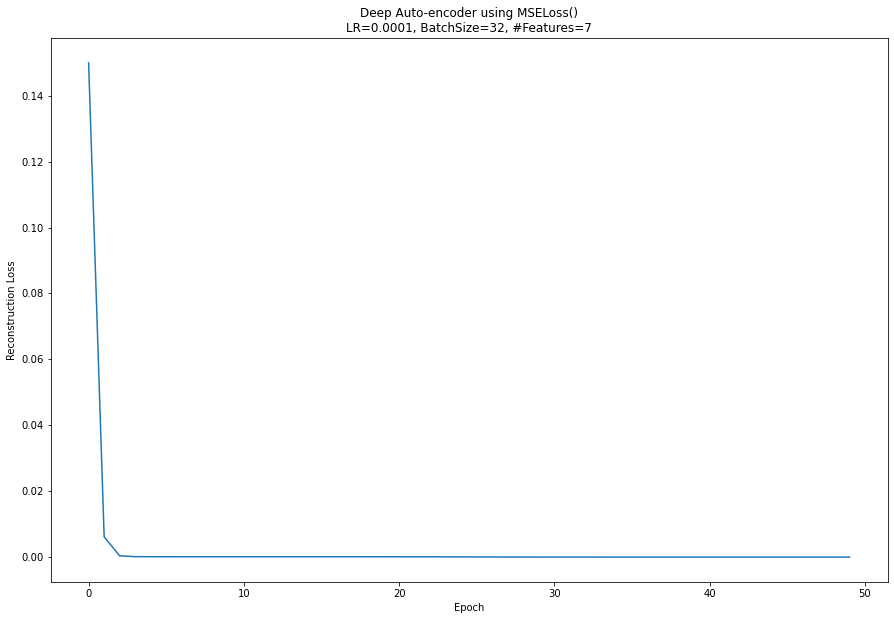

In [218]:
_, ax = plt.subplots(1,1,figsize=(15,10))
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
ax.set_title(f'Deep Auto-encoder using {loss_function}\n{hyperparam_description}')
ax.plot(train_loss)

In [468]:
# Calculate reconstruction loss for test partition (mixed flow data)
test_loss = []
net.eval()
test_tensor = torch.tensor(test_X.values.astype(np.float32))
loss_function = nn.MSELoss()

items = []
items2 = []

with torch.no_grad():
    for i in range(len(test_X)):
        inputs = test_tensor[i].to(device=device)
        output = net(inputs).to(device=device)
        loss = loss_function(output, inputs).to(device=device)
        test_loss.append(loss.item())

/users/grad/fali/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [469]:
a = np.array(test_loss)
np.percentile(a, 99)

8.041274904826421e-06

Selected Attack Threshold: 3.939523594453931e-06
Theshold yields TPR: 0.8508, FPR: 0.0180
AUC: 0.9810


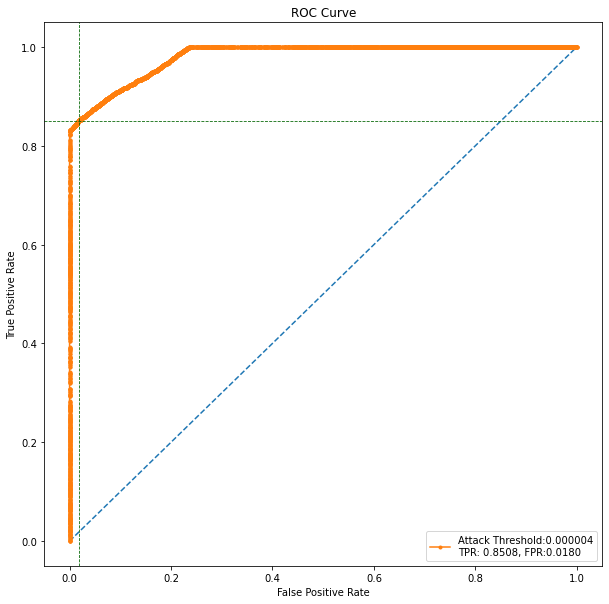

In [470]:
fpr, tpr, thresholds = roc_curve(y_true=test_y.astype(int), y_score=test_loss, pos_label=1)
ranked_thresholds = sorted(list(zip(np.abs(tpr - fpr), thresholds, tpr, fpr)), key=lambda i: i[0], reverse=True)
_, attack_threshold, threshold_tpr, threshold_fpr = ranked_thresholds[0]
print(f"Selected Attack Threshold: {attack_threshold}")
print("Theshold yields TPR: {:.4f}, FPR: {:.4f}".format(threshold_tpr, threshold_fpr))

auc = roc_auc_score(y_true=test_y.astype(int),  y_score=test_loss)
print("AUC: {:.4f}".format(auc))

plt.figure(figsize=(10, 10))
plt.plot([0,1], [0,1], linestyle="--") # plot baseline curve
plt.plot(fpr, tpr, marker=".", label="Attack Threshold:{:.6f}\nTPR: {:.4f}, FPR:{:.4f}".format(attack_threshold, threshold_tpr, threshold_fpr))
plt.axhline(y=threshold_tpr, color='darkgreen', lw=0.8, ls='--')
plt.axvline(x=threshold_fpr, color='darkgreen', lw=0.8, ls='--')
plt.title("ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")

              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     23352
      attack       0.95      0.84      0.89      4376

    accuracy                           0.97     27728
   macro avg       0.96      0.92      0.94     27728
weighted avg       0.97      0.97      0.97     27728



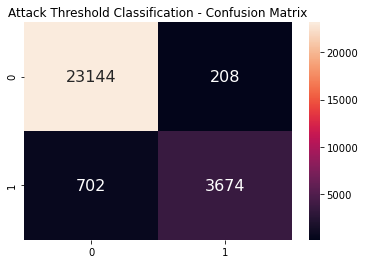

In [483]:
attack_threshold = np.percentile(a, 86)
test_results = test_y.to_frame().astype(bool)
test_results['loss'] = pd.Series(test_loss, index=test_results.index)
test_results['is_attack_prediction'] = test_results.loss >= attack_threshold

conf_matrix = confusion_matrix(test_results.is_attack, test_results.is_attack_prediction)
plt.figure()
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt='g')
plt.title('Attack Threshold Classification - Confusion Matrix')
print(classification_report(test_results.is_attack, test_results.is_attack_prediction, target_names=["benign", "attack"]))

23352


/users/grad/fali/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


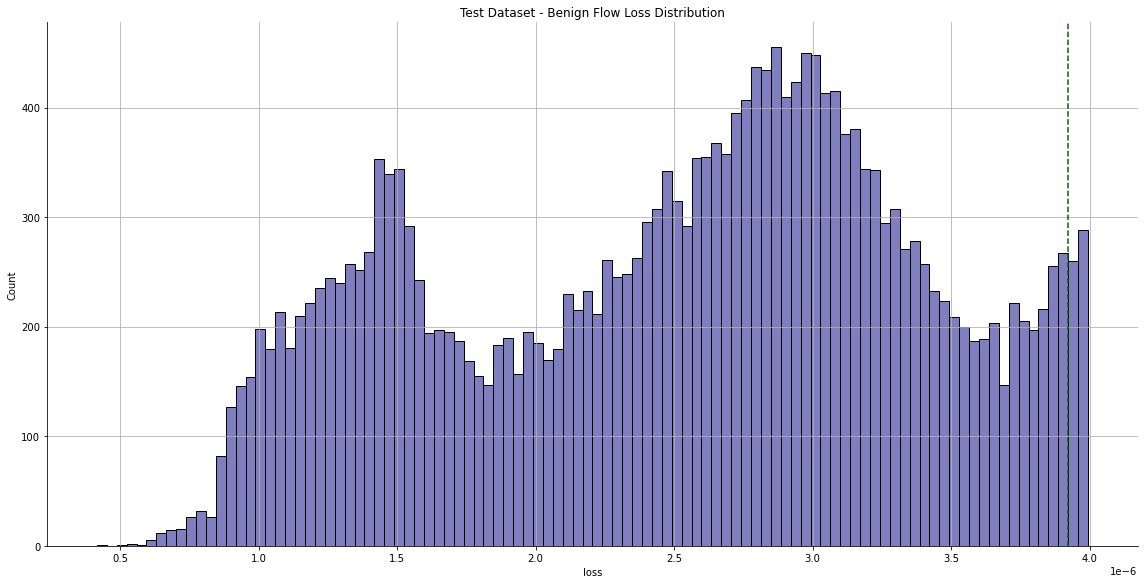

In [472]:
benign_loss = test_results[test_results['is_attack'] == False].loss
benign_loss = benign_loss[benign_loss<0.0001838608441175893]
# benign_loss = benign_loss[benign_loss<max(benign_loss)]
print(len(benign_loss))
sns.displot(benign_loss, bins=100, kde=True, color='navy', height=8, aspect=2)
plt.axvline(attack_threshold, 0.0, 10, color='darkgreen', linestyle='dashed')
plt.title('Test Dataset - Benign Flow Loss Distribution')
plt.grid(True)

/users/grad/fali/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


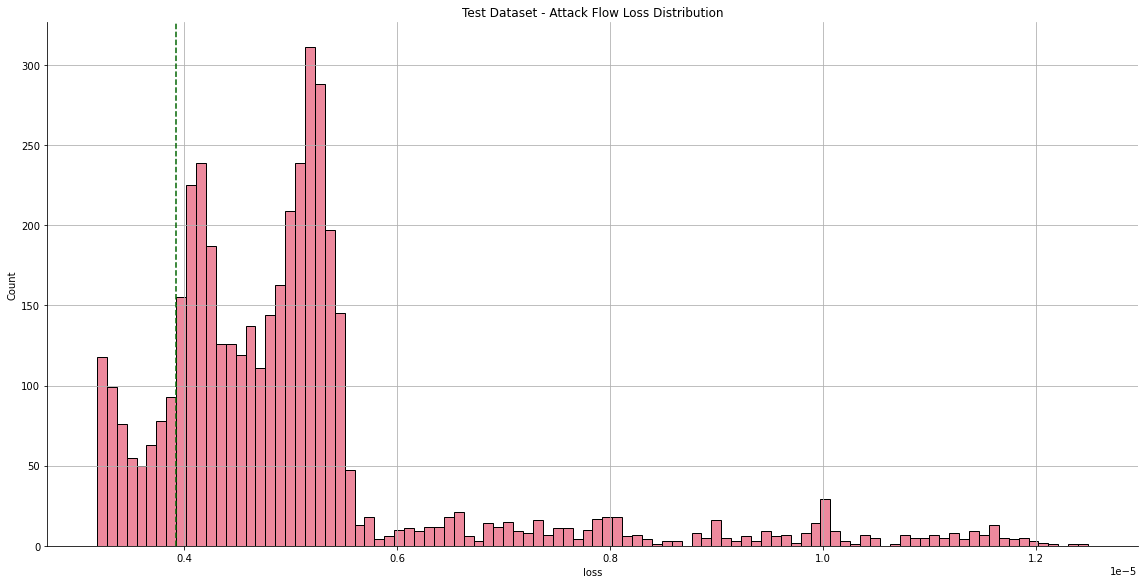

In [473]:
attack_loss = test_results[test_results['is_attack'] == True].loss
attack_loss = attack_loss[attack_loss<0.0001537241142615676]
sns.displot(attack_loss, bins=100, kde=True, color='crimson', height=8, aspect=2)
plt.axvline(attack_threshold, 0.0, 10, color='darkgreen', linestyle='dashed')
plt.title('Test Dataset - Attack Flow Loss Distribution')
plt.grid(True)

/users/grad/fali/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


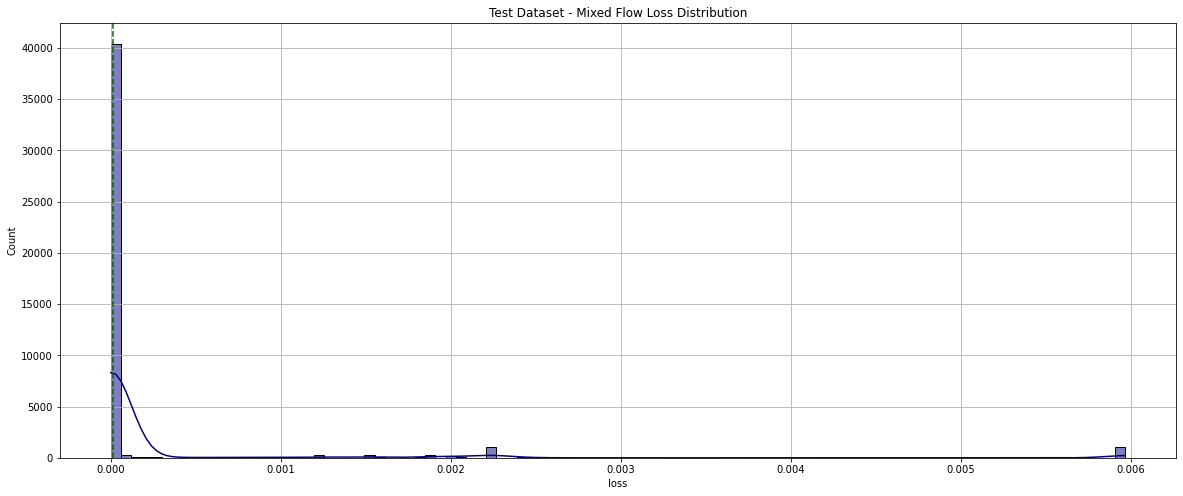

In [376]:
fig, ax = plt.subplots(figsize=(20, 8))
attack_loss = test_results[test_results['is_attack'] == True].loss
benign_loss = test_results[test_results['is_attack'] == False].loss
sns.histplot(benign_loss, ax=ax, bins=100, kde=True, color='navy', alpha=0.5)
sns.histplot(attack_loss, ax=ax, bins=100, kde=True, color='crimson', alpha=0.5)

plt.axvline(attack_threshold, 0.0, 10, color='darkgreen', linestyle='dashed')
plt.title('Test Dataset - Mixed Flow Loss Distribution')
ax.grid(True)

In [30]:
# Calculating loss for training-set on trained model (for toubleshooting distributions)
post_train_loss = [] 
net.eval()
train_tensor = torch.tensor(train_X.values.astype(np.float32))

with torch.no_grad():
    for i in range(len(train_X)):
        input = train_tensor[i].to(device=device)
        output = net(input).to(device=device)
        loss = loss_function(output, input).to(device=device)
        post_train_loss.append(loss.item())

/users/grad/fali/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/users/grad/fali/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


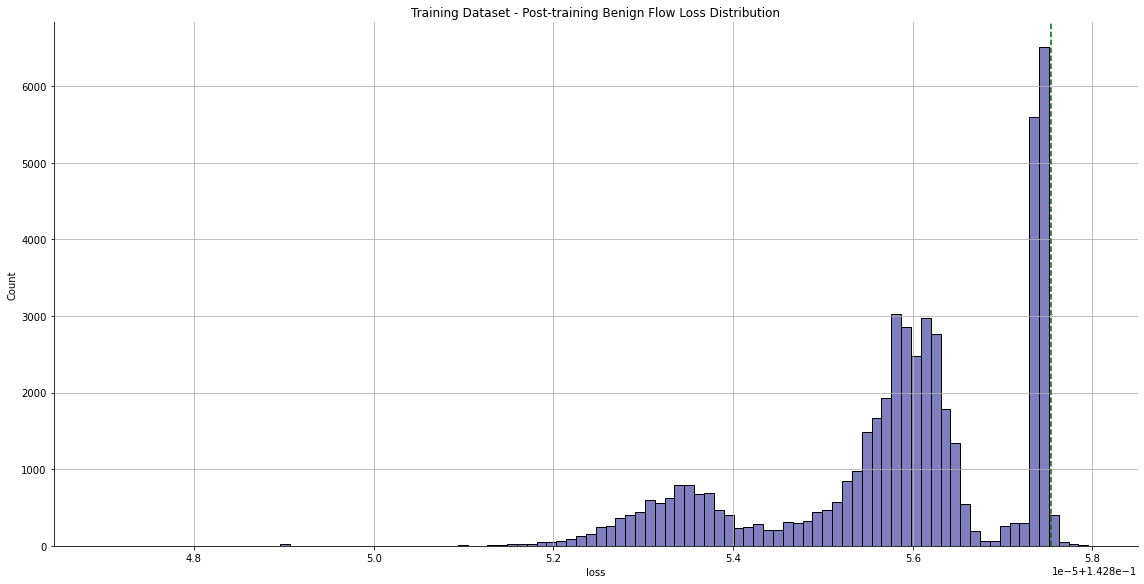

In [124]:
# Graph loss density for training set post training
post_train_results = pd.DataFrame({'is_attack': [False] * len(post_train_loss)})
post_train_results['loss'] = pd.Series(post_train_loss, index=post_train_results.index)
post_train_results['is_attack_prediction'] = post_train_results.loss > attack_threshold

sns.displot(post_train_results.loss, bins=100, kde=True, color='navy', height=8, aspect=2)
plt.axvline(attack_threshold, 0.0, 10, color='darkgreen', linestyle='dashed')
plt.title('Training Dataset - Post-training Benign Flow Loss Distribution')
plt.grid(True)

In [465]:

#         if loss.item() > 3.1759739158587763e-06 and test_y.iloc[i] == True:
#             items.append(i)
#         elif test_y.iloc[i] == False and loss.item() < 3.98451329242496286e-06:
#             items2.append(i)
#         break

mixed_flows.iloc[items].to_csv('/users/grad/fali/attack/tran_mixed_50k_samples.csv')
mixed_flows.iloc[items2].to_csv('/users/grad/fali/attack/tran_mixed_50k_samples2.csv')